In [1]:
import numpy as np
import numpy.ma as ma

from astropy.table import QTable, Table
from astropy.io import fits

import sys
sys.path.insert(1,"/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/")
#sys.path.insert(1, '/home/kelly/Documents/RotationCurves/spirals/')
from DRP_rotation_curve import extract_data, extract_Pipe3d_data
from disk_mass import calc_mass_curve, fit_mass_curve

sys.path.insert(1, '/Users/kellydouglass/Documents/Research/Rotation_curves/Yifan_Zhang/RotationCurve/2D_RC/main/')
from rotation_curve_functions import disk_mass

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
SDSS_FOLDER = '/Users/kellydouglass/Documents/Research/data/SDSS/'

MASS_MAP_FOLDER = SDSS_FOLDER + 'dr15/manga/spectro/pipe3d/v2_4_3/2.4.3/'
VEL_MAP_FOLDER = SDSS_FOLDER + 'dr16/manga/spectro/analysis/v2_4_3/2.2.1/HYB10-GAU-MILESHC/'
MASS_CURVE_MASTER_FOLDER = '../spirals/Pipe3d-mass_curve_data_files/'

# Sample galaxy properties

In [109]:
#gal_ID = '7443-12705'
gal_ID = '8139-12703'

manga_plate, manga_IFU = gal_ID.split('-')

In [110]:
_,_, map_mask, r_band,_,_,_,_,_,_,_ = extract_data(VEL_MAP_FOLDER, gal_ID)

sMass_density = extract_Pipe3d_data(MASS_MAP_FOLDER, gal_ID)

mr_band = ma.array(r_band, mask=map_mask)

In [111]:
'''
oneD_fit_file = '../spirals/DRPall-master_file_30.txt'

oneD_fit_parameters = QTable.read(oneD_fit_file, format='ascii.ecsv')

gal_oneD_fit_parameters_boolean = np.logical_and(oneD_fit_parameters['MaNGA_plate'] == int(manga_plate), 
                                                 oneD_fit_parameters['MaNGA_IFU'] == int(manga_IFU))

gal_oneD_fit_parameters_row = oneD_fit_parameters[gal_oneD_fit_parameters_boolean]
'''

map_fit_file = '../spirals/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_morph_v6.txt'

map_fit_parameters = Table.read(map_fit_file, format='ascii.commented_header')

gal_map_fit_parameters_boolean = (map_fit_parameters['MaNGA_plate'] == int(manga_plate)) & \
                                 (map_fit_parameters['MaNGA_IFU'] == int(manga_IFU))

gal_map_fit_parameters_row = map_fit_parameters[gal_map_fit_parameters_boolean]

In [112]:
H_0 = 100      # Hubble's Constant in units of h km/s/Mpc
c = 299792.458 # Speed of light in units of km/s

MANGA_FIBER_DIAMETER = 2*(1/60)*(1/60)*(np.pi/180) # angular fiber diameter (2") in radians
MANGA_SPAXEL_SIZE = 0.5*(1/60)*(1/60)*(np.pi/180)  # spaxel size (0.5") in radians

#z = gal_oneD_fit_parameters_row['redshift'][0]
z = gal_map_fit_parameters_row['NSA_redshift'][0]

dist_to_galaxy_Mpc = c*z/H_0
dist_to_galaxy_kpc = dist_to_galaxy_Mpc*1000

pix_scale_factor = dist_to_galaxy_kpc*np.tan(MANGA_SPAXEL_SIZE)

In [113]:
################################################################################
# Axis ratio (from photometry)
#-------------------------------------------------------------------------------
#axis_ratio = gal_oneD_fit_parameters_row['ba'][0]
axis_ratio = gal_map_fit_parameters_row['ba_map'][0]
################################################################################


################################################################################
# Center of galaxy
#
# Originally used photometric center, now using kinematic center
#-------------------------------------------------------------------------------
'''
center = np.unravel_index(ma.argmax(mr_band), mr_band.shape)

center_x = center[1]
center_y = center[0]
''';

center_x = gal_map_fit_parameters_row['x0_map'][0]
center_y = gal_map_fit_parameters_row['y0_map'][0]
################################################################################


################################################################################
# Systemic velocity (velocity at galaxy's center)
#-------------------------------------------------------------------------------
#v_sys = mHa_vel[center]
################################################################################


################################################################################
# Rotation angle (from photometry)
#-------------------------------------------------------------------------------
#phi = gal_oneD_fit_parameters_row['phi'][0].value
phi = gal_map_fit_parameters_row['phi_map'][0]

#phi_guess = find_phi(center, phi, mHa_vel)
################################################################################


################################################################################
# Maximum velocity
#-------------------------------------------------------------------------------
#v_max = gal_oneD_fit_parameters_row['avg_v_max'][0].value
v_max = gal_map_fit_parameters_row['Vmax_map'][0]

#v_max_index = np.unravel_index(ma.argmax(np.abs(mHa_vel)), mHa_vel.shape)
#v_max_guess = np.abs(mHa_vel[v_max_index]/np.sin(i_angle))
################################################################################


################################################################################
# Turn radius
#-------------------------------------------------------------------------------
#r_turn = gal_oneD_fit_parameters_row['avg_r_turn'][0].value
r_turn = gal_map_fit_parameters_row['Rturn_map'][0]
'''
r_turn_guess_spaxels,_ = deproject_spaxel(v_max_index, 
                                          center, 
                                          phi_guess, 
                                          i_angle)

r_turn_guess = 0.5*r_turn_guess_spaxels*pix_scale_factor

if r_turn_guess < 0.01:
    r_turn_guess = 1.1*0.01
''';
################################################################################


################################################################################
# alpha
#-------------------------------------------------------------------------------
#alpha = gal_oneD_fit_parameters_row['avg_alpha'][0]
alpha = gal_map_fit_parameters_row['alpha_map'][0]

#alpha_guess = 2
################################################################################

In [114]:
map_shape = r_band.shape

# Test `calc_mass_curve`

<IPython.core.display.Javascript object>


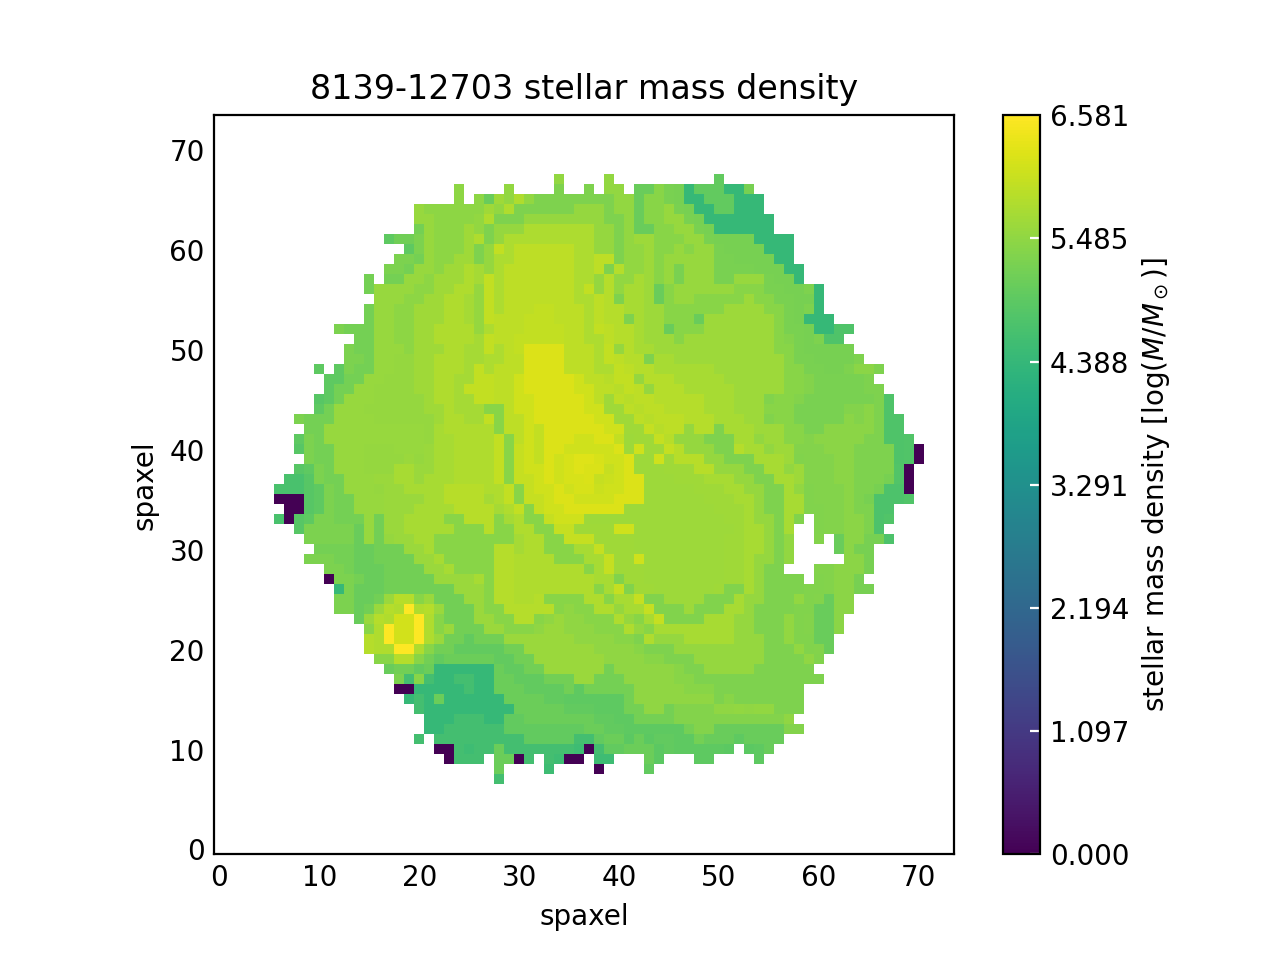

In [115]:
mass_data_table = calc_mass_curve(sMass_density, 
                                  r_band, 
                                  map_mask, 
                                  center_x,
                                  center_y,
                                  axis_ratio, 
                                  phi, 
                                  z, 
                                  gal_ID)

# Test `fit_mass_curve`

In [33]:
from rotation_curve_functions import disk_vel

r_sample = np.linspace(0.01,15,100)

test_params = [0.01, 2.5]

#v_sample = disk_vel(test_params, r_sample)
v_sample = disk_vel(r_sample, test_params[0], test_params[1])

<IPython.core.display.Javascript object>


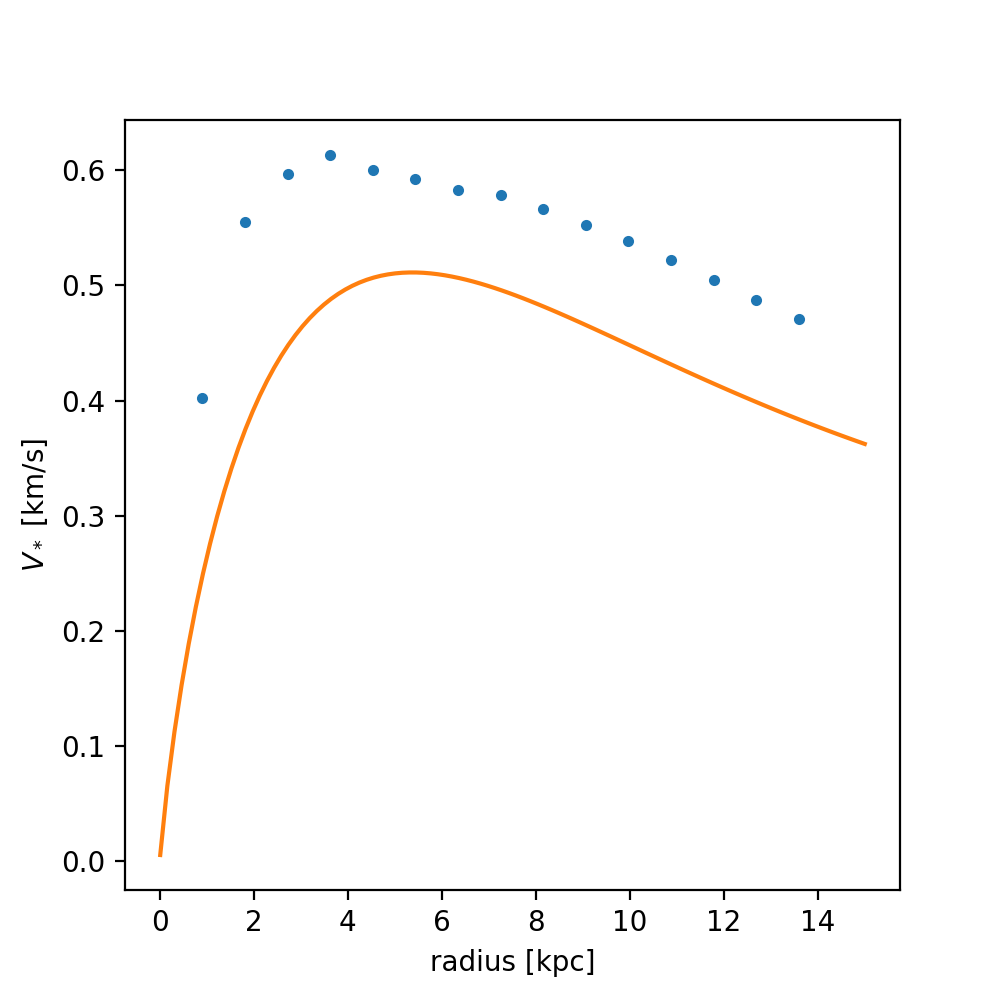

In [34]:
plt.figure(figsize=(5,5))

plt.plot(mass_data_table['radius'], mass_data_table['star_vel'], '.')
plt.plot(r_sample, v_sample)

plt.xlabel('radius [kpc]')
plt.ylabel('$V_*$ [km/s]');

/Users/kellydouglass/Documents/Research/Rotation_curves/Yifan_Zhang/RotationCurve/2D_RC/main/rotation_curve_functions.py:321: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(vel2) / 1000


<IPython.core.display.Javascript object>


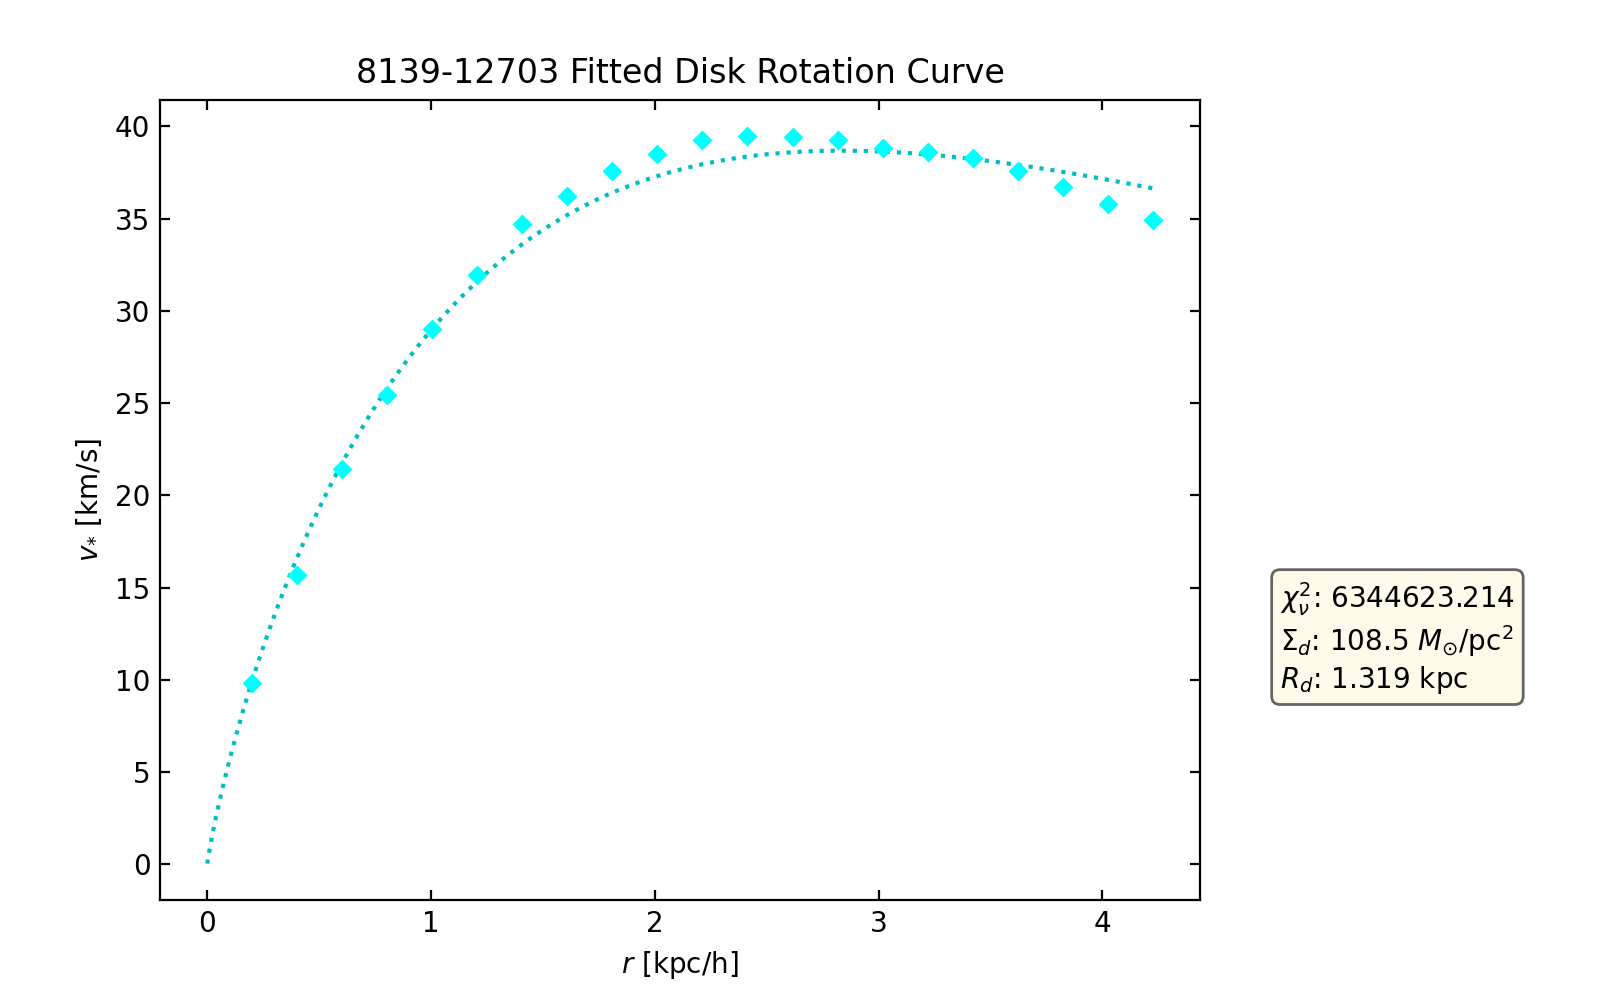

/Users/kellydouglass/Documents/Research/Rotation_curves/Yifan_Zhang/RotationCurve/2D_RC/main/rotation_curve_functions.py:318: RuntimeWarning: invalid value encountered in multiply
  bessel_component = (iv(0, y) * kn(0, y) - iv(1, y) * kn(1, y))


In [116]:
param_outputs = fit_mass_curve(mass_data_table, gal_ID)

In [117]:
mass_data_table

radius,M_star,star_vel,star_vel_err
float64,float64,float64,float64
0.20120043389572784,6.654008972646939,9.816814266391248,0.00011031285228103975
0.4024008677914557,7.360888685476212,15.663738813188916,0.0001760155238735401
0.6036013016871835,7.8083790022161645,21.40892997525766,0.0002405750038422493
0.8048017355829113,8.083545604249478,25.451236958442394,0.00028599894698817547
1.0060021694786392,8.295069140843072,29.04127345415844,0.0003263406662963731
...,...,...,...
3.2192069423316454,9.047702588888281,38.61512020007444,0.0004339232601180024
3.4204073762273732,9.066440744950626,38.279124803456,0.0004301476349968087
3.621607810123101,9.075740407117534,37.60105573715545,0.0004225280823886638


# Test `disk_mass`

In [14]:
M90_disk, M90_disk_err = disk_mass(param_outputs, mass_data_table['radius'][-1])

print(M90_disk, M90_disk_err)

10.719219925707309 12.535164389473493
